In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
# connectome will be installed automatically, because `amid` depends on it

!pip install amid

# Converting image background white to black

In [29]:
from amid.rsna_bc import RSNABreastCancer

ds = RSNABreastCancer('/kaggle/input/rsna-breast-cancer-detection/')


In [30]:
dir(ds)

['BIRADS',
 'age',
 'biopsy',
 'cancer',
 'density',
 'difficult_negative_case',
 'id',
 'ids',
 'image',
 'image_id',
 'implant',
 'intensity_sign',
 'invasive',
 'laterality',
 'machine_id',
 'padding_value',
 'patient_id',
 'prediction_id',
 'site_id',
 'view']

In [31]:
len(ds.ids)

54710

In [32]:
i = ds.ids[0]
i

'1000030932'

In [33]:
ds.age(i), ds.implant(i), ds.cancer(i), ds.view(i)

(69.0, False, False, 'CC')

In [34]:
import matplotlib.pyplot as plt

def show(x):
    plt.imshow(x, cmap='gray')

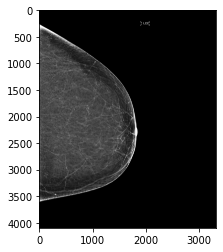

In [35]:
show(ds.image(i))

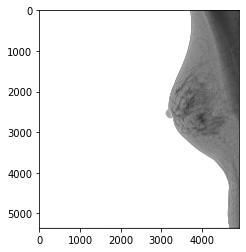

In [36]:
i2 = '2028281852'
show(ds.image(i2))

In [37]:
from connectome import Transform


class Normalize(Transform):
    """
    Inverts the image intensity if necessary, so that the background is always zero
    """

    __inherit__ = True # inherit all fields from the previous layer

    def image(image, padding_value, intensity_sign):
        if padding_value is not None:
            if padding_value > 0:
                return padding_value - image
            return image
        
        # if no padding value is available, we can conpute it ourselves
        if intensity_sign == 1:
            return image.max() - image

        return image

In [38]:
dataset = ds >> Normalize()

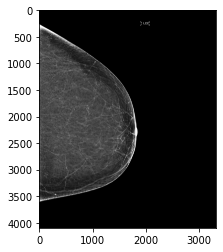

In [39]:
# nothing changed here, the bg was already black
show(dataset.image(i))

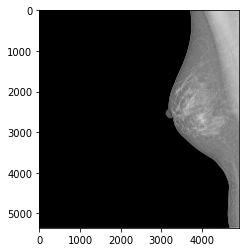

In [40]:
# but this one got normalized
show(dataset.image(i2))

# Crop the background

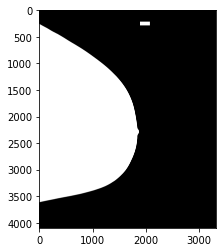

In [41]:
show(dataset.image(i) > 0)

In [42]:
class CropBackground(Transform):
    __inherit__ = True
    
    def image(image):
        mask = image > 0
        xs, = mask.any(0).nonzero()
        ys, = mask.any(1).nonzero()
        return image[ys.min():ys.max() + 1, xs.min():xs.max() + 1]

In [43]:
from connectome import Chain


# Chain(a, b, c) is a more convenient way to write a >> b >> c
dataset = Chain(
    ds,
    Normalize(),
    CropBackground(),
)

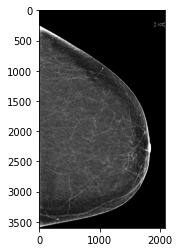

In [44]:
show(dataset.image(i))

# Remove the label

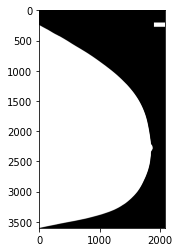

In [45]:
show(dataset.image(i) > 0)

In [46]:
from skimage.morphology import label
import numpy as np


class GetGreatestComponent(Transform):
    __inherit__ = True
    
    def image(image):
        # find all the connected components
        lbl = label(image > 0)
        # caclulate their sizes
        values, counts = np.unique(lbl, return_counts=True)
        # 0 is always the background - we don't need it
        foreground = values != 0
        component = values[foreground][counts[foreground].argmax()]
        # select all the components greater than the background
        #  + the greatest foreground component
        components = set(values[counts > counts[~foreground]]) | {component}
        if len(components) > 1:
            # if there are several components - pick the one with the greatest intensity
            component = max(components, key=lambda c: image[lbl == c].mean())

        return image * (lbl == component)

In [47]:
dataset = Chain(
    ds,
    Normalize(),
    GetGreatestComponent(),
    CropBackground(),
)

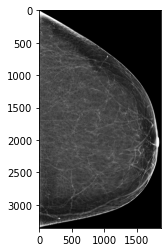

In [48]:
show(dataset.image(i))